# <center>Environmental Sound Classification</center>
---



## Intstall important libraries.

In [2]:
!pip3 install librosa

## Import important libraries

In [0]:
import tensorflow as tf
import librosa
import time
import librosa.display
import numpy as np
import pandas as pd
import random
from IPython.display import Audio
from scipy.io import wavfile
from itertools import chain
import matplotlib.pyplot as plt
import re

## Clone the github repository where data is placed.

*   It will take  1 to 2 minuts to clone.

*   1st github repository(provided by you) for training the model.

*   2nd github repository which is mine, which keep a sound file to test the model, it's because colab  is showing error when i am trying to write the code. so kept it on github.


In [4]:
!git clone https://github.com/karoldvl/ESC-50.git
!git clone https://github.com/bheemnitd/Sound-Classification-Keras.git
# may be you can see this
# "fatal: destination path 'ESC-50' already exists and is not an empty directory."
# ignore it(it's already cloned that's why it display this message)

fatal: destination path 'ESC-50' already exists and is not an empty directory.
fatal: destination path 'Sound-Classification-Keras' already exists and is not an empty directory.


## Now the dataset is stored in colab, hence we can access the dataset easly

In [5]:
audio_files = librosa.util.find_files('ESC-50/audio/', ext=['wav']) 
audio_files = np.array(audio_files)
print("number of audio files:",len(audio_files),'\n')
print(audio_files)

number of audio files: 2000 

['/content/ESC-50/audio/1-100032-A-0.wav'
 '/content/ESC-50/audio/1-100038-A-14.wav'
 '/content/ESC-50/audio/1-100210-A-36.wav' ...
 '/content/ESC-50/audio/5-51149-A-25.wav'
 '/content/ESC-50/audio/5-61635-A-8.wav'
 '/content/ESC-50/audio/5-9032-A-0.wav']


## Explore the dataset.




*   Randomly selected two files from audio dataset




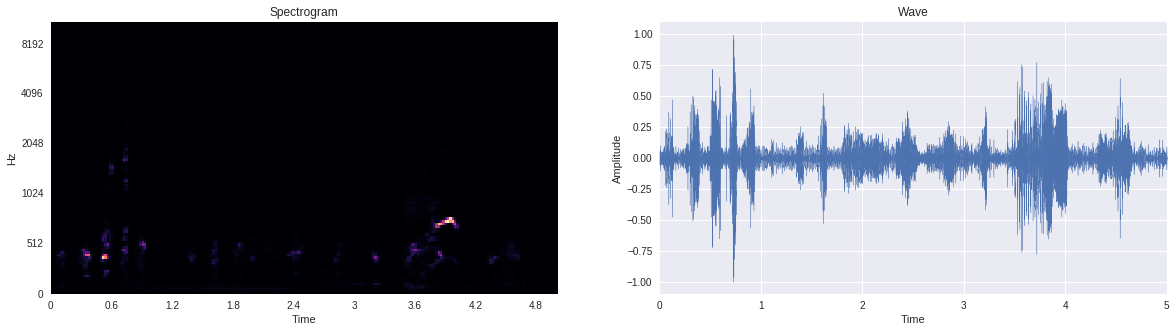

In [6]:
# Generating spectogram form from audio file.
plt.figure(figsize=(20,5))
plt.subplot(121)
data, sampling_rate = librosa.load(audio_files[random.randint(0,2000)], duration=5.0)
spectrogram = librosa.feature.melspectrogram(data, sampling_rate)
plt.title("Spectrogram")
librosa.display.specshow(spectrogram, y_axis='mel', x_axis='time')

# Generating wave form from audio file.
plt.subplot(122)
plt.title("Wave")
librosa.display.waveplot(data, sr=sampling_rate)
plt.ylabel('Amplitude')
plt.show()

#Audio
Audio(data,rate = sampling_rate)

In [7]:
print("diamention of spectrogram:",spectrogram.shape)
print("sampling_rate:",sampling_rate)

diamention of spectrogram: (128, 216)
sampling_rate: 22050


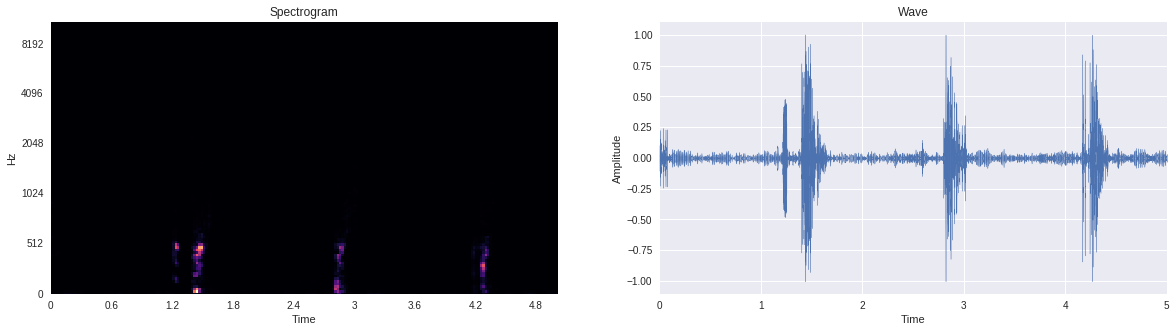

In [8]:
# Generating spectogram form from audio file.
plt.figure(figsize=(20,5))
plt.subplot(121)
data, sampling_rate = librosa.load(audio_files[random.randint(0,2000)], duration=5.0)
spectrogram = librosa.feature.melspectrogram(data, sampling_rate)
plt.title("Spectrogram")
librosa.display.specshow(spectrogram, y_axis='mel', x_axis='time')

# Generating wave form from audio file.
plt.subplot(122)
plt.title("Wave")
librosa.display.waveplot(data, sr=sampling_rate)
plt.ylabel('Amplitude')
plt.show()

# Audio
Audio(data,rate = sampling_rate)

## Fetch the dataset from colab.



*   fetching the data from colab into variable to performing the task.
*   it will take 5 to 6 minutes
*  here "res_type" used to fetch the data fast from colab.
*  here "temporary _audio_files" keep original audio files




In [0]:
number_of_audio_files = len(audio_files)
temporary_audio_files = []
for i in range(number_of_audio_files):
  temporary_audio_file, sampling_rate = librosa.load(audio_files[i],res_type='kaiser_fast')
  temporary_audio_files.append(temporary_audio_file)

## Augmentation of 5seconds audio files.

* Adding  white noise and shifted sound.
Let's see

In [0]:
# It will take less than one minute for augmentation.
size_of_audio_files = len(temporary_audio_files[0])
augmented_audio_files1 = []
augmented_audio_files2 = []

for i in range(number_of_audio_files): 
  # Adding white noise
  augmented_audio_files1.append(temporary_audio_files[i] + 0.005*np.random.randn(size_of_audio_files))
  #Shifting the sound
  augmented_audio_files2.append(np.roll(temporary_audio_files[i], sampling_rate//10))
  


*   Loading all the training dataset in the one variable  "augmented_audio_files3"

*   Click on ignore when "memory uses close to the limit" dialog box is apeared

*   If Runtime died run from start to **"Fetch the dataset from colab."** and after that start from **"Augmentation"** to last

In [0]:
#after running this cell our number of training example will becomes 6000
augmented_audio_files3 = list(temporary_audio_files)
augmented_audio_files3.extend(augmented_audio_files1)
augmented_audio_files3.extend(augmented_audio_files2)
augmented_audio_files3 = np.array(augmented_audio_files3)

## Increasing number of target(y) corresponding to training example.


In [9]:
# extracting target
superviser = []
for i in range(2000):
  exp = re.findall('\d{1,2}.wav',audio_files[i])
  superviser.append(int(float(exp[0][0:2]))) 

# increasing the target
y = [superviser]*3
y = list(chain.from_iterable(y))
print("number of training example:",len(augmented_audio_files3))
print("number of target(updated superviser):",len(y))

number of training example: 6000
number of target(updated superviser): 6000


## Generating spectrogram of augmented 5seconds audio files

*   wait for 5 to 6 minutes.



In [0]:
augmented_spectrogram_files = []
number_of_training_example = len(augmented_audio_files3)
for i in range(number_of_training_example):
  augmented_spectrogram_files.append(librosa.feature.melspectrogram(augmented_audio_files3[i], sampling_rate))
augmented_spectrogram_files = np.array(augmented_spectrogram_files)

## Split into training and testing dataset

In [0]:
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(augmented_spectrogram_files, y,test_size = 0.1,random_state=5)

## Training the model
*    create the model
*    compile the model
*    train the model

In [12]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(augmented_spectrogram_files[0].shape)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(50, activation=tf.nn.softmax)

])

# compile the model
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# train the model
t0 = time.time()
model.fit(train_x,train_y, epochs=10)
print("\ntraining time:", round(time.time()-t0, 3), "seconds") # the time would be round to 3 decimal in seconds

print("\ntest accuracy:")
# test the model
model.evaluate(test_x,test_y)

Epoch 1/10
5400/5400 [==============================] - 7s 1ms/step - loss: 10.5612 - acc: 0.1578
Epoch 2/10
5400/5400 [==============================] - 2s 462us/step - loss: 9.1237 - acc: 0.3081
Epoch 3/10
5400/5400 [==============================] - 2s 460us/step - loss: 8.9611 - acc: 0.3456
Epoch 4/10
5400/5400 [==============================] - 2s 451us/step - loss: 8.4217 - acc: 0.3993
Epoch 5/10
5400/5400 [==============================] - 3s 475us/step - loss: 8.0955 - acc: 0.4348
Epoch 6/10
5400/5400 [==============================] - 3s 473us/step - loss: 7.9245 - acc: 0.4604
Epoch 7/10
5400/5400 [==============================] - 3s 474us/step - loss: 7.8437 - acc: 0.4683
Epoch 8/10
5400/5400 [==============================] - 3s 470us/step - loss: 7.7278 - acc: 0.4776
Epoch 9/10
5400/5400 [==============================] - 3s 464us/step - loss: 7.7600 - acc: 0.4778
Epoch 10/10
5400/5400 [==============================] - 2s 451us/step - loss: 7.6491 - acc: 0.4885

training 

[9.22294595082601, 0.3333333333333333]

## prediction of my input audio.

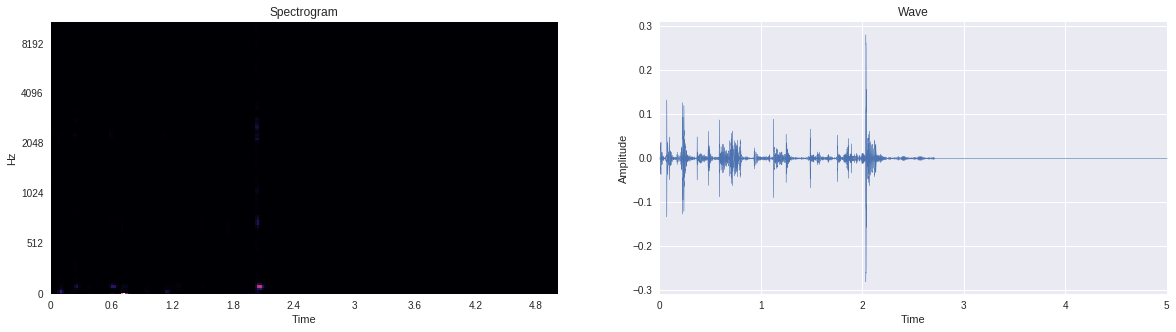

predicted subclass: Keyboard typing
Predicted class: Interior/domestic sounds 

Prediction may become wrong because of poor training accuracy.



In [16]:
# Classes
subclasses =['Dog','Rooster','Pig','Cow','Frog','Cat','Hen','Insects (flying)','Sheep','Crow',
'Rain','Sea waves','Crackling fire','Crickets','Chirping birds','Water drops','Wind','Pouring water','Toilet flush','Thunderstorm',
'Crying baby','Sneezing','Clapping','Breathing','Coughing','Footsteps','Laughing','Brushing teeth','Snoring','Drinking/sipping',
'Door knock','Mouse click','Keyboard typing','Door', 'wood creaks','Can opening','Washing machine','Vacuum cleaner','Clock alarm','Clock tick','Glass breaking'
'Helicopter','Chainsaw','Siren','Car horn','Engine','Train','Church bells','Airplane','Fireworks','Hand saw']

classes = ['Animals',	'Natural soundscapes & water sounds',	'Human/ non-speech sounds',	'Interior/domestic sounds',	'Exterior/urban noises']

# Fetchin my audio from colab(cloned from my github repository)
cough_sound = librosa.util.find_files('Sound-Classification-Keras/', ext=['wav']) 

# Generating spectogram form from audio file.
plt.figure(figsize=(20,5))
plt.subplot(121)
data, sampling_rate = librosa.load(audio_files[random.randint(0,2000)], duration=5.0)
spectrogram = librosa.feature.melspectrogram(data, sampling_rate)
plt.title("Spectrogram")
librosa.display.specshow(spectrogram, y_axis='mel', x_axis='time')

# Generating wave form from audio file.
plt.subplot(122)
plt.title("Wave")
librosa.display.waveplot(data, sr=sampling_rate)
plt.ylabel('Amplitude')
plt.show()

#Prediction
spectrogram = np.array([spectrogram])
prediction = list(model.predict(spectrogram)[0])
print("predicted subclass:",subclasses[prediction.index(max(prediction))])
print("Predicted class:",classes[subclasses.index(subclasses[prediction.index(max(prediction))])//10],"\n")
print("Prediction may become wrong because of poor training accuracy.\n")


#Audio
Audio(data,rate = sampling_rate)